## 機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます

## 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）


・51から55行目 : ライブラリのimport

・57から62行目 : ハイパーパラメータの設定

《文字単位のトークン化》


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。


[sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [6]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

# ハイパーパラメーター
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# txtデータ読み込み
data_path = 'fra.txt'

# ベクトル化した文を格納するリスト
input_texts = []
target_texts = []

# 文章内に存在する単語格納
input_characters = set()
target_characters = set()

# txtデータ読み込み文章抽出
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

# 文章から文抽出、for文
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)

    # 単語抽出し、格納
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# ソート
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

# エン、デコーダーの数決める
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

# 文の数からデータ数を設定
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

# printで確認
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


# 単語と紐づけ
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

#　エンコーダデコーダそれぞれにinputするデータと教師データの型となる変数を定義
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# for文で、文入力し、教師データと比較して学習していく
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # 文から単語抽出
    for t, char in enumerate(input_text):
        # ベクトル化
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

# seq2seqモデル
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# コンパイル
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
# 学習
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# 保存
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# 予測モデル
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

# 隠れ状態ベクトルを生成し、それを元に、　文章を生成する関数を定義
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

#実際に文章生成を行うfor文を回す
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 2s 17ms/step - loss: 1.1684 - accuracy: 0.7255 - val_loss: 1.0369 - val_accuracy: 0.7030
Epoch 2/100
125/125 [==============================] - 1s 11ms/step - loss: 0.8336 - accuracy: 0.7741 - val_loss: 0.8201 - val_accuracy: 0.7720
Epoch 3/100
125/125 [==============================] - 1s 11ms/step - loss: 0.6723 - accuracy: 0.8104 - val_loss: 0.7111 - val_accuracy: 0.7923
Epoch 4/100
125/125 [==============================] - 1s 11ms/step - loss: 0.5875 - accuracy: 0.8291 - val_loss: 0.6585 - val_accuracy: 0.8057
Epoch 5/100
125/125 [==============================] - 1s 11ms/step - loss: 0.5383 - accuracy: 0.8427 - val_loss: 0.6071 - val_accuracy: 0.8184
Epoch 6/100
125/125 [==============================] - 1s 11ms/step - loss: 0.5030 - accuracy: 0.8522 - val_loss: 0

## 回答

コードに記述

## 日本語でもやってみる

In [9]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

# ハイパーパラメーター
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# txtデータ読み込み
data_path = 'jpn.txt'

# ベクトル化した文を格納するリスト
input_texts = []
target_texts = []

# 文章内に存在する単語格納
input_characters = set()
target_characters = set()

# txtデータ読み込み文章抽出
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

# 文章から文抽出、for文
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)

    # 単語抽出し、格納
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# ソート
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

# エン、デコーダーの数決める
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

# 文の数からデータ数を設定
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

# printで確認
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


# 単語と紐づけ
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

#　エンコーダデコーダそれぞれにinputするデータと教師データの型となる変数を定義
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# for文で、文入力し、教師データと比較して学習していく
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # 文から単語抽出
    for t, char in enumerate(input_text):
        # ベクトル化
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# seq2seqモデル
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# コンパイル
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
# 学習
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# 保存
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# 予測モデル
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

# 隠れ状態ベクトルを生成し、それを元に、　文章を生成する関数を定義
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

#実際に文章生成を行うfor文を回す
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


Number of samples: 10000
Number of unique input tokens: 72
Number of unique output tokens: 1454
Max sequence length for inputs: 20
Max sequence length for outputs: 36
Epoch 1/100
125/125 [==============================] - 5s 41ms/step - loss: 1.2415 - accuracy: 0.0461 - val_loss: 1.4373 - val_accuracy: 0.0537
Epoch 2/100
125/125 [==============================] - 4s 35ms/step - loss: 1.1249 - accuracy: 0.0682 - val_loss: 1.2822 - val_accuracy: 0.0947
Epoch 3/100
125/125 [==============================] - 4s 36ms/step - loss: 1.0046 - accuracy: 0.0922 - val_loss: 1.1716 - val_accuracy: 0.1112
Epoch 4/100
125/125 [==============================] - 4s 36ms/step - loss: 0.9085 - accuracy: 0.1068 - val_loss: 1.0840 - val_accuracy: 0.1242
Epoch 5/100
125/125 [==============================] - 4s 36ms/step - loss: 0.8401 - accuracy: 0.1179 - val_loss: 1.0302 - val_accuracy: 0.1344
Epoch 6/100
125/125 [==============================] - 4s 35ms/step - loss: 0.7871 - accuracy: 0.1273 - val_loss:

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。


[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

## 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [27]:
import os

In [24]:
pwd

'/content/drive/My Drive'

In [25]:
!git clone https://github.com/yunjey/pytorch-tutorial.git


Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 21.49 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [28]:
os.chdir('/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning')
print(os.getcwd())

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [29]:
!unzip "/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/models/pretrained_model.zip"

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/models
Archive:  /content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/models/pretrained_model.zip
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [43]:
os.chdir('/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/data')
print(os.getcwd())
!unzip "/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocap.zip"

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/data
Archive:  /content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocap.zip
  inflating: vocab.pkl               


In [44]:
%cd /content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [46]:
pwd

'/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning'

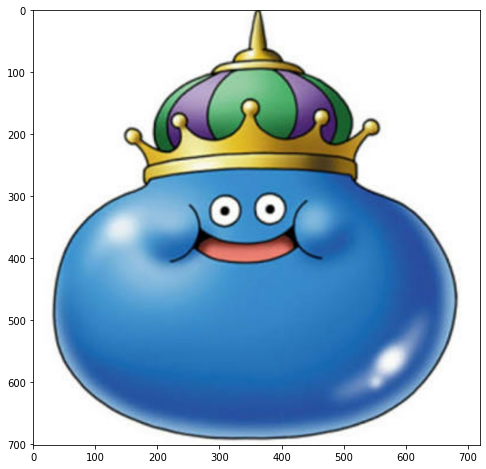

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100% 230M/230M [00:09<00:00, 26.3MB/s]
<start> a close up of a red and white cake <end>


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

im = Image.open("/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/king.jpg")
im_list = np.asarray(im)
plt.figure(figsize=(10, 8))
plt.imshow(im_list)
plt.show()


!python sample.py --image='king.jpg' --encoder_path='models/encoder-5-3000.pkl' --decoder_path='models/decoder-5-3000.pkl'

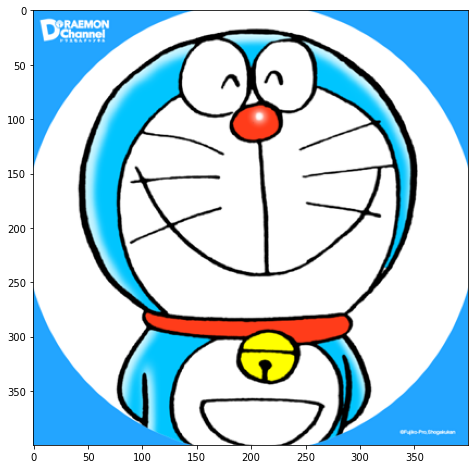

<start> a close up of a cake with a fork . <end>


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

im = Image.open("/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/dra.png")
im_list = np.asarray(im)
plt.figure(figsize=(10, 8))
plt.imshow(im_list)
plt.show()


!python sample.py --image='dra.png' --encoder_path='models/encoder-5-3000.pkl' --decoder_path='models/decoder-5-3000.pkl'

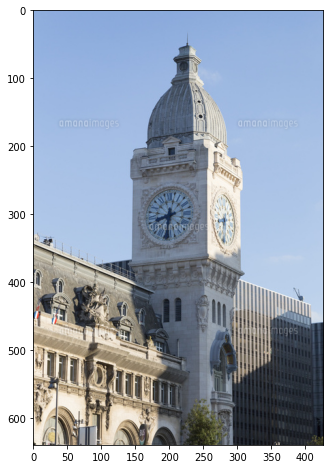

<start> a clock tower with a clock on top of it . <end>


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

im = Image.open("/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/time.jpg")
im_list = np.asarray(im)
plt.figure(figsize=(10, 8))
plt.imshow(im_list)
plt.show()


!python sample.py --image='time.jpg' --encoder_path='models/encoder-5-3000.pkl' --decoder_path='models/decoder-5-3000.pkl'

## 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

相互変換ツールMMdnn使用

・pip install mmdnn

・mmdownload -f pytorch 学習済みモデルの入手

・mmconvert -sf pytorch -iw imagenet_inception_v3.pth -df keras -om imagenet_inception_v3.h5で変換

[参考](https://qiita.com/koppe/items/7f85f5411539390c4499)

## 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

## 【問題5】（アドバンス課題）発展的調査

《他の言語の翻訳を行う場合は？》


問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。


《機械翻訳の発展的手法にはどのようなものがある？》


機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。


《文章から画像生成するには？》


イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。